# Using Incomplete Cholesky Decomposition on OKGT - an Experiment

**Note: Laplace kernels are used throughout this experiment.**

When $X$ is of high dimensional, chances are we are dealing with a large covariance matrix of $R_{XX}$. If the same size is $N$ and the number of groups (i.e. dimensions) is $l$, then the covariance matrix is of size $lN \times lN$. This would causes the computation time of the OKGT training very long. 

In order to improve the computation time, we borrow the idea from Bach&Jordan(2002) where they use Incomplete Cholesky Decomposition (ICD) to approximate the Gram matrices so that the dimension of the training problem would be much smaller. 

They also worked out a predictive version of ICD, where information from the response $Y$ is used while decomposing $X$. But in our experiment, we will use the non-predictive version.

The detailed derivation of the algorithm is in a separate document (to be updated). This notebook shows the detailed implementation. 

In order to compare the ICD version of OKGT training, we will compare the results with that from running the non-ICD version. 	


Before we do anything, we first simulate the data for the rest of the notebook. 

The model is from [this post](http://partofthething.com/ace/samples.html). The following is the model representation:

$$
Y = \ln (4 + \sin(4X_0)) + |X_1| + X_2^2 + X_3^3 + X_4 + 0.1\epsilon
$$

where $\epsilon \sim N(0,1)$ and each covariate is simulated from $Unif(-1,1)$.

In [2]:
# Simulate data
import okgtreg.simulate as simulate
import okgtreg.kernel_selector as ks
import numpy as np
import scipy as sp

np.random.seed(10)
n = 500
y, x = simulate.SimData_Wang04(500)
y = np.matrix(y)
x = np.matrix(x)

We also specify the parameters for OKGT. They will be used for both non-ICD and ICD version.

In [13]:
eps = 1e-6 # regularization term

p = x.shape[1]
xGroup = [[i+1] for i in range(p)]
# kfn = ks.KernelSelector('Gaussian', sigma=0.5) # Gaussian kernel
kfn = ks.KernelSelector('Laplace', alpha=0.005) # Laplace kernel
xkfnlist = [kfn]*p
ykfnlist = [kfn]

Here, we assume each covariate constitutes a group by itself. All groups share the same kernel function which is Gaussian with $\sigma = 0.5$. It is also the kernel function for the response.

## Non-ICD Version

We will first run an simulation from the non-ICD version. The results will be used as the benchmark.

In [14]:
# ---------------------
# Orignal construction
# ---------------------
from okgtreg.okgtreg import *
import okgtreg.kernel_selector as ks

# Construct covariance and cross-covariance operators
Rxx, Gx = OKGTReg.CovOperator_directSum(x, xkfnlist, xGroup=xGroup)
Ryy, Gy = OKGTReg.CovOperator_directSum(y, ykfnlist)
Ryx = Gy * Gx.T / n

# Take the inverse of R_XX.
# With high dimensional data, this will becomes the computation bottle neck.
Rxx_inv = np.linalg.inv(Rxx + eps * np.identity(n*p))

# Factorize the covariance matrix for Y
D, P = np.linalg.eigh(Ryy + eps * np.identity(n)) # regularization is added here
D = D[::-1]
P = P[:, ::-1]
D_inv = np.matrix(np.diag(1. / np.sqrt(D)))
Gy_inv = D_inv * P.T # Ryy^{-1/2}

# The main matrix from which is the largest eigen-value will be taken.
VyxVxy = Gy_inv * Ryx * Rxx_inv * Ryx.T * Gy_inv.T

# Eigen-decompose VV.
# The largest eigen value is the R^2.
# The corresponding eigen vector contains the kernel expansion coefficients for the optimal transformation of Y, i.e. g(Y)
r2, beta = slinalg.eigh(VyxVxy, eigvals=(n-1, n-1)) # only need the largest eigen value and vector
beta = np.matrix(beta)
zeta = D_inv * beta
zeta = P * zeta
g_opt = Gy * zeta

# By projecting g(Y) onto the kernel additive space of X,
# we get the optimal transformations for the covariates.
x_i = Ryx.T * g_opt
x_i = Rxx_inv * x_i
f_opt_ls = []
for i in range(p):
    x_ii = x_i[i*n : (i+1)*n]
    Gx_i = Gx[i*n : (i+1)*n, :]
    f_i_opt = Gx_i * x_ii
    f_i_norm = np.sqrt(x_ii.T * f_i_opt)
    f_i_opt = f_i_opt / f_i_norm
    f_opt_ls.append(f_i_opt)

f_opt = np.column_stack(f_opt_ls)

The estimated $R^2$ is:

In [15]:
print 'R2 =', float(r2), '\n'
print 'R =', float(np.sqrt(r2))

R2 = 0.951785869558 

R = 0.975595136088


We can also calculate the Pearson correlation between $\hat{g}(y)$ and $\sum \hat{f}_i(x_i)$:

In [16]:
print 'Pearson correlation =', float(sp.stats.pearsonr(g_opt, f_opt.sum(axis=1))[0])

Pearson correlation = 0.902586648453


<font color='red'>The Pearson correlation of the transformed data is lower than $R$.</font>

Finally, the following plots show the transformation functions for each variable.

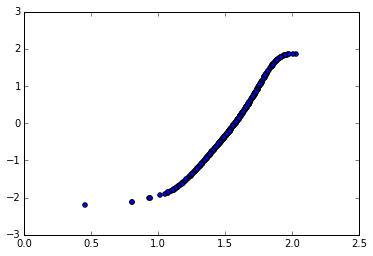

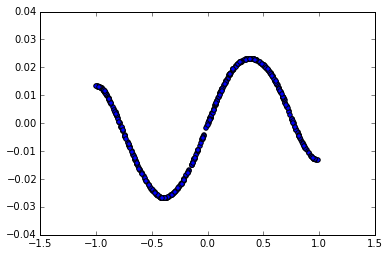

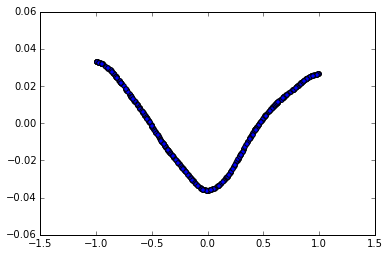

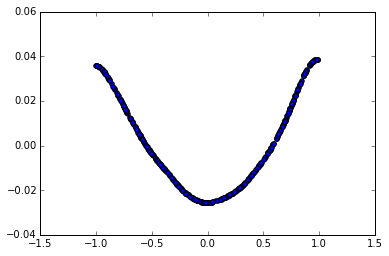

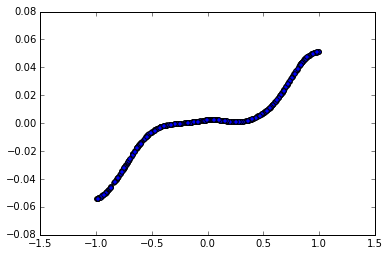

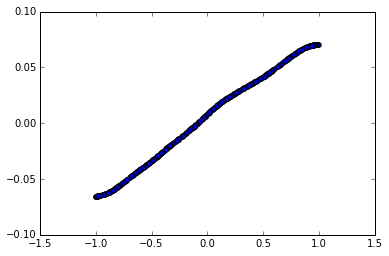

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure()
plt.scatter(y, g_opt)
plt.show() 

plt.figure()
plt.scatter(x[:,0], f_opt[:,0])
plt.show()

plt.figure()
plt.scatter(x[:,1], f_opt[:,1])
plt.show()

plt.figure()
plt.scatter(x[:,2], f_opt[:,2])
plt.show()

plt.figure()
plt.scatter(x[:,3], f_opt[:,3])
plt.show()

plt.figure()
plt.scatter(x[:,4], f_opt[:,4])
plt.show()

The above plots show that the transformations based on the simulated data are quite close to the true model.

# ICD Version

The section above shows the benchmark algorithm. In the following, we will apply a modified version of OKGT training, where all Gram matrices are replaced by their approximations. The approximation is done by using ICD. Let $K$ be a Gram matrix ($N \times N$), then

\begin{align*}
   K \approx G * G^T \\
   G = U D V^T
\end{align*}

where $G$ is a $N \times M$ matrix (M < N), and the second equation is due to applying SVD on $G$, so $U^T U = I$.

Since usually $K$ has eigen values which decay fast, the first approximation would be good even when $M$ is small. 

By putting them together, we have:

$$
    K \approx U D^2 U^T = U \Lambda U^T
$$

where the diagonal matrix $\Lambda$ ($M \times M$) contains the $M$ largest eigen values of $K$.

How ICD is used in OKGT training is detailed in a separate document.

Another consideration is that OKGT traning requires centered Gram matrices. One can center the Gram matrices before using ICD, but Back&Jordan(2002) says:

>Centering, which would make the diagonal elements different from one and make the other elements harder to compute, can be done easily after the Cholesky decomposition.

So, we did the following:

1. Decompose the uncentered Gram matrix $K \approx GG^T$;
2. Multiply by the cenering matrix $(I - \frac{1}{N}\boldsymbol{1})K(I - \frac{1}{N}\boldsymbol{1}) \approx (I - \frac{1}{N}\boldsymbol{1})GG^T(I - \frac{1}{N}\boldsymbol{1})$;
3. Apply SVD on $\tilde{G} = (I - \frac{1}{N}\boldsymbol{1})G$

In [18]:
import pymc.gp.incomplete_chol as pyichol
from sklearn.metrics.pairwise import pairwise_distances

# The following functions will be used later

def ApplyICDonSymmetricMatrix(K, centerG=True):
    """
    Apply Incomplete Cholesky Decomposition on an uncentered Gram matrix.

    A Gram matrix K (n*n) assumes the following approximation:

        K \approx G * G^T
        G = U*S*V

    where G is a n*m matrix (m < n), which can be SVD decomposed. So U^T * U = I.

    So by combining them, we have:

        K \approx U * Lambda * U^T

    where Lambda = S^2, which is the m leading eigen values of K.

    Reference:
        2002, Bach and Jordan, Kernel Independent Component Analysis, Journal of Machine Learning Research

    :param K: numpy matrix, uncentered Gram matrix

    :param centerG: boolean, True by default.
        If True, G is centered. In particular, centered G will be used to approximate the centered K, i.e.

            (I - Ones/n) * K * (I - Ones/n) \approx G * G^T

        after permuting K according to pind.

    :return:
        U: numpy matrix, a n*m lower triangular matrix such that U^T * U = I.
        Lambda: 1-d numpy array, vector of m leading eigen-values of K.
        pind: 1-d numpy array of int32, vector of permutation indices, which are the column numbers of K in the same order as ICD retains them.
    """
    # Center the Gram matrix first then apply decomposition
    # if centerK:
    #     n = K.shape[0]
    #     I = np.matrix(np.identity(n))
    #     Ones = np.matrix(np.ones((n,n)))
    #     # K = np.einsum('ij, jk, lk', I - Ones/n, K, I - Ones/n) # slow
    #     K = (I - Ones/n) * K * (I - Ones/n)
    #     K = (K + K.T)/2 # force symmetry

    # ICD
    reltol = 1e-6
    L, m, pind = pyichol.ichol_full(K, reltol)
    G = np.matrix(L[:m].T)
    n = G.shape[0]

    if centerG:
        I = np.identity(n)
        Ones = np.matrix(np.ones((n, n)))
        G = (I - Ones/n) * G  # (column) centered G

    # SVD
    U, d, V = np.linalg.svd(G, full_matrices=False)
    Lambda = d**2 # eigen values of Gram matrix

    return U, Lambda, pind


def ReducedGramMatrix_ICD(x, kernel_fn):
        """
        Get U and Lambda from a Gram matrix.
        The Gram matrix is constructed from the given data and kernel function.

        :param x: numpy matrix.
                (part of) the data matrix. If it is the reponse y, then it is a n*1 matrix (one column).
                If it is the predictor, the number of columns of the matrix is the same as the size of a group.
                For example,
                    if x = (X_1, X_2), then it is a n*2 matrix.

        :param kernel_fn: callable returne from <KernelSelector>. It is a bivariate kernel function.

        :return:
            U: numpy matrix, a n*m lower triangular matrix such that U^T * U = I.
            Lambda: 1-d numpy array, vector of m leading eigen-values of K.
        """
        K = np.matrix(pairwise_distances(x, metric=kernel_fn))
        U, Lambda, pind = ApplyICDonSymmetricMatrix(K)
        return U, Lambda


def StackUandLambda(x, kernelFnsList, stackDiag=False, **kwargs):
        """
        Construct the row stack block matrix: [U_1, U_2, ..., U_l].

        :param x: numpy matrix. Design matrix for predictor variables.
        :param kernelFnsList: list of kernel functions, each is a callable returned from kernel_selector.KernelSelector.
        :param kwargs: additional keyword arguments.
                    If x is multivariate or high dimensional, provide the group information.
                    List of lists, same as <xGroup>.

        :return:
            numpy.matrix
            numpy.array
        """
        l = len(kernelFnsList)

        if l>1:
            U_list = []
            Lambda_list = []
            for i in range(l):
                ind = [a-1 for a in xGroup[i]] # variable indices for group i
                x_groupi = x[:,ind]
                U_i, Lambda_i = ReducedGramMatrix_ICD(x_groupi, kernelFnsList[i])
                # print Lambda_i
                U_list.append(U_i)
                Lambda_list.append(Lambda_i)
            
            URowStack = np.hstack(U_list)
            LambdaStack = np.hstack(Lambda_list)
            
            if stackDiag:
                UDiagBlock = sp.sparse.block_diag(U_list).todense()
                return URowStack, LambdaStack, UDiagBlock
            else:
                return URowStack, LambdaStack
        else:
            URowStack, LambdaStack = ReducedGramMatrix_ICD(x, kernelFnsList[0])
            return URowStack, LambdaStack

In [19]:
# Apply ICD, Centering, SVD.
# Also, stack some matrices together for future computation.
Ux, Lambdax, Ux_dblock = StackUandLambda(x, xkfnlist, stackDiag=True, xGroup=xGroup)
Uy, Lambday = StackUandLambda(y, ykfnlist)

mx = Ux.shape[1] # reduced dimension of X
my = Uy.shape[1] # reduced dimension of Y

In [20]:
# print mx, my

In [21]:
# Construct necessary matrices for compute VV. Details are in the separate document.
T = np.matrix(np.diag( Lambday / (Lambday + eps) )) * Uy.T * Ux * np.matrix(np.diag( Lambdax ))
R = np.matrix(np.diag( (Lambdax+eps)**2 )) + \
        np.diag(Lambdax) * ( Ux.T * Ux - np.matrix(np.identity(mx)) ) * np.diag(Lambdax)
# R has size M*M, so the inverse is fast.
R_inv = np.linalg.inv(R) 

# We don't explicitely evaluate VV, instead the eigen decomposition only needs a M*M matrix.
eigval, eigvec = sp.linalg.eigh(T * R_inv * T.T, eigvals=(my-1,my-1))

The largest eigen value should be the estimated $R^2$, which is lower than that from the benchmark algorithm.

In [22]:
print 'R^2 (ICD) =', float(eigval), '\n'
print 'R (ICD) =', float(np.sqrt(eigval))

R^2 (ICD) = 0.995843707503 

R (ICD) = 0.997919689907


The corresponding eigen vector is of size $M_y$, which are the loadings of the expansion of the optimal transformation for the response Y, i.e. $\hat{g}(Y)$. This can be seen from the following where $K$ is the centered Gram matrix, $b$ is the eigen vector obtained above, and $\beta$ is expansion coefficient in the origninal N-dimensional space. 

\begin{align*}
    \hat{g}(Y) 
        &= K_y * \beta \\
        &\approx U_y \Lambda_y U_y^T \beta \\
        &\approx U_y \Lambda_y U_y^T U_y b \\
        &=U_y \Lambda_y b
\end{align*}

In [23]:
# Optimal transformation for Y, if ICD is used
g_opt_ICD = Uy * np.matrix(np.diag(Lambday)) * eigvec

The following shows that plot of transformation $g(Y)$:

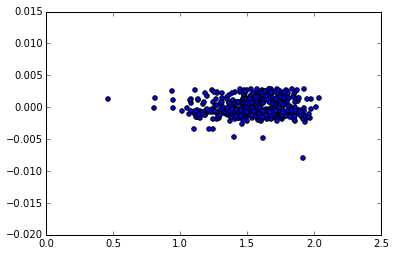

In [24]:
plt.scatter(y, g_opt_ICD)

**The transformation is no way close to the true model.**

Then by projecting $g$ to the additive kernel space of $X$, we can obtain the optimal transformations for the covariates.

In [25]:
x_i = Uy * np.diag(Lambday) * Uy.T * g_opt_ICD
# x_i = Ux_dblock * R_inv * np.matrix(np.diag(Lambdax)) * Ux.T * x_i
x_i = R_inv * np.matrix(np.diag(Lambdax)) * Ux.T * x_i
f_opt_ICD = Ux_dblock * np.matrix(np.diag(Lambdax)) * x_i
f_opt_ICD = f_opt_ICD.reshape((n,p), order='F')

The Pearson correlation between $\hat{g}$ and $\sum \hat{f}_i$ is:

In [26]:
print 'Pearson correlation (ICD) =', float(sp.stats.pearsonr(g_opt_ICD, f_opt_ICD.sum(axis=1))[0])

Pearson correlation (ICD) = 0.952544645069


The Pearson correlation and the estimated $R$ are closer to each other than between those obtained in the benchmark section. <font color='red'>Is this true in general? In particular, the reduced rank estimate of $R$ estimated the correlation better? Due to avoiding overfitting? Need simulation to investigate that.</font>

Finally, the following plots show the transformations for the covariates:

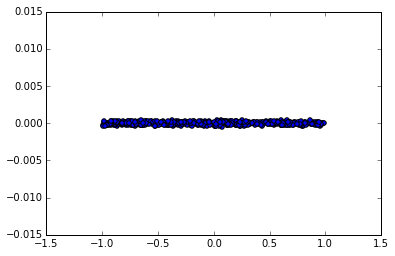

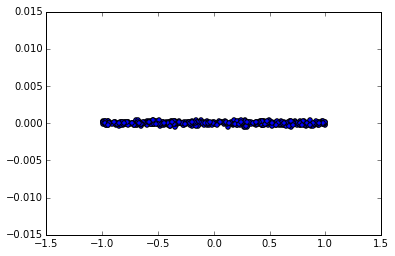

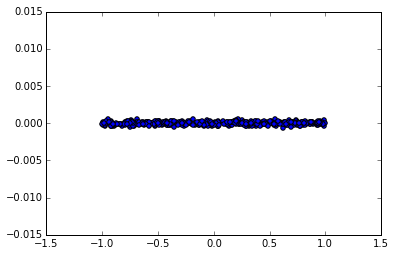

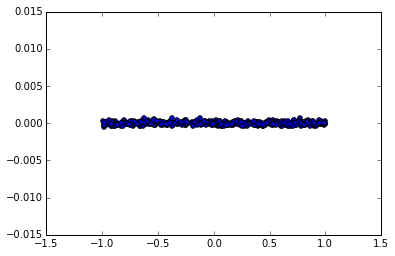

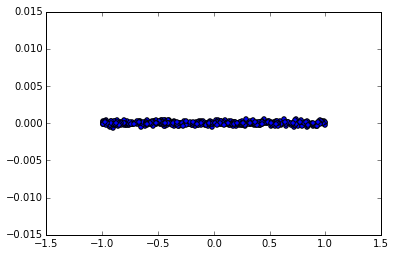

In [27]:
plt.figure()
plt.scatter(x[:,0], f_opt_ICD[:,0])
plt.show()

plt.figure()
plt.scatter(x[:,1], f_opt_ICD[:,1])
plt.show()

plt.figure()
plt.scatter(x[:,2], f_opt_ICD[:,2])
plt.show()

plt.figure()
plt.scatter(x[:,3], f_opt_ICD[:,3])
plt.show()

plt.figure()
plt.scatter(x[:,4], f_opt_ICD[:,4])
plt.show()

**The transformations are way off.**